# Introduction

This is a cleaner version of the framework prototype. 

The steps will be encapsulated in a function, and called one after another after.

We will use the easy toy dataset generated in v1.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from pycpd import RigidRegistration
from sklearn.neighbors import KNeighborsClassifier

from functools import partial
from cycpd import rigid_registration, affine_registration, deformable_registration
from PIL import Image


In [5]:
df = pd.read_csv("../data/toy_data_2batches_2pops.csv", index_col=0)
df.head()

,CD69,CD99,Population,Batch
0,2.729573,14.642127,pop_1,ref
1,2.108741,15.071990,pop_1,ref
2,3.222132,15.074051,pop_1,ref
3,1.758534,14.243902,pop_1,ref
4,3.125349,15.468494,pop_1,ref


Separate the dataframe into reference (this will be soulcap reference data in the future) and new data from user.

In [6]:
df_ref = df[(df['Batch'] == 'ref')]

df_new = df[(df['Batch'] == 'batch_1')]
# rename the batch to user data
df_new.loc[:, 'Batch'] = 'user_data'
df_new.head()

,CD69,CD99,Population,Batch
10000,8.690130,29.869319,pop_1,user_data
10001,9.409027,30.775588,pop_1,user_data
10002,10.149282,30.735540,pop_1,user_data
10003,9.771453,31.757215,pop_1,user_data
10004,8.461216,30.831674,pop_1,user_data


# PPM

First, pretend we already have PPM generated for our reference and new data.

In [8]:
def generate_ppm(x_vals, y_vals, grid_size=32):
    # grid_size = [10, 32]
    # x then y (x=10, y=32)
    # if one value, then square grid.
    # cartesian plotting and numpy 2d histogram has 2 different orientation.
    # 1st argument in histogram2d is x-axis (CD69), but becomes rows in output.
    # 2nd argument in histogram2d is y-axis (CD99), but becomes columns in output.
    ppm, xedges, yedges = np.histogram2d(
        x=x_vals, 
        y=y_vals, 
        bins=grid_size
    )

    # note the ppm output here, x_vals (CD69) will be rows
    # y_vals (CD99) is columns.
    # it's just the way numpy intrepret x and y differently from us.

    # Normalize to get probabilities
    total_cells = len(x_vals)
    ppm = ppm / total_cells

    xcenters = 0.5 * (xedges[:-1] + xedges[1:])
    ycenters = 0.5 * (yedges[:-1] + yedges[1:])

    # get bin ids and probabilities
    # get position and index of bins
    bin_coords = []
    bin_id = 0
    for x_idx in range(len(xcenters)):
        for y_idx in range(len(ycenters)):
            bin_coords.append([
                f"bin_{x_idx}_{y_idx}",
                xedges[x_idx],
                xedges[x_idx+1],
                xcenters[x_idx],
                yedges[y_idx],
                yedges[y_idx+1],
                ycenters[y_idx],
                ppm[x_idx, y_idx]
            ])
            bin_id += 1
    bin_coords = pd.DataFrame(bin_coords, columns=["bin_id", "x_min", "x_max", "x_center", "y_min", "y_max", "y_center", "prob"])

    # Find bin index for each point
    # Default behavior is (right==False) indicating that the interval does not include the right edge.
    # Subtract 1 to get 0-based bin index
    x_bin = np.digitize(x_vals, xedges) - 1  
    # digitize operate off the bin edges.
    # any value that is >= last bin edge will be given the len(xedges) id.
    # which does not exist as we only have len(xedges)-1 bins.
    # hence we need to clip the bins so it maxed out at number of bins - 1
    x_bin = np.clip(x_bin, 0, grid_size - 1)

    y_bin = np.digitize(y_vals, yedges) - 1
    y_bin = np.clip(y_bin, 0, grid_size - 1)

    bin_ids = [f"bin_{x_idx}_{y_idx}" for x_idx, y_idx in zip(x_bin, y_bin)]

    return bin_coords, bin_ids

Generate PPM for the reference and new data.

In [ ]:
ppm_ref_bin_coords, bin_ids = generate_ppm(
    x_vals=df_ref['CD69'].to_numpy(),
    y_vals=df_ref['CD99'].to_numpy(),
    grid_size=32
)
df_ref_with_bins = df_ref.copy(deep=True)
df_ref_with_bins.loc[:, 'bin_id'] = bin_ids

ppm_dat_bin_coords, bin_ids = generate_ppm(
    x_vals=df_new['CD69'].to_numpy(),
    y_vals=df_new['CD99'].to_numpy(),
    grid_size=32
)
df_new_with_bins = df_new.copy(deep=True)
df_new_with_bins.loc[:, 'bin_id'] = bin_ids


Sanity check the bins and points assignments

In [10]:
for x, bin_id in zip(df_ref_with_bins['CD69'], df_ref_with_bins['bin_id']):
     bin_coord = ppm_ref_bin_coords[ppm_ref_bin_coords['bin_id'] == bin_id]
     if not (x >= bin_coord['x_min'].values[0] and x <= bin_coord['x_max'].values[0]):
          print(f"{x}, {bin_id}, oops")

for y, bin_id in zip(df_ref_with_bins['CD99'], df_ref_with_bins['bin_id']):
     bin_coord = ppm_ref_bin_coords[ppm_ref_bin_coords['bin_id'] == bin_id]
     if not (y >= bin_coord['y_min'].values[0] and y <= bin_coord['y_max'].values[0]):
          print(f"{y}, {bin_id}, oops")

Text(0.5, 1.0, 'PPM New data')

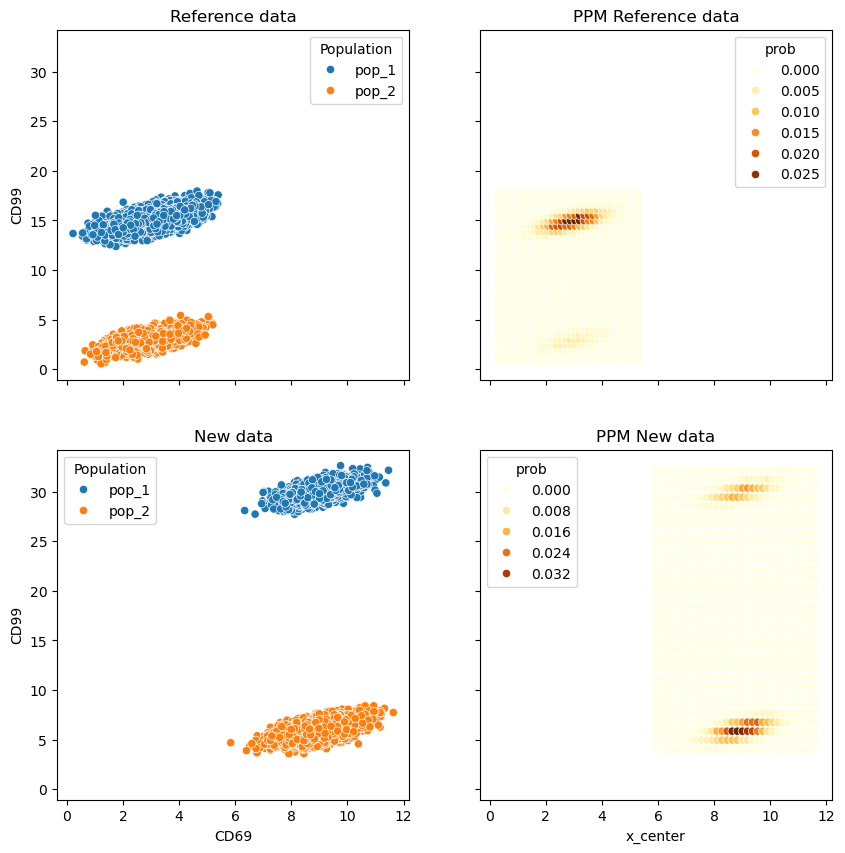

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)

# plot the reference data first
sns.scatterplot(
    data=df_ref_with_bins,
    x='CD69',
    y='CD99',
    hue='Population',
    ax=ax[0][0]
).set_title("Reference data")

# plot the reference data first
sns.scatterplot(
    data=ppm_ref_bin_coords,
    x='x_center',
    y='y_center',
    hue='prob',
    ax=ax[0][1],
    palette='YlOrBr'
).set_title("PPM Reference data")

sns.scatterplot(
    data=df_new_with_bins,
    x='CD69',
    y='CD99',
    hue='Population',
    ax=ax[1][0]
).set_title("New data")

sns.scatterplot(
    data=ppm_dat_bin_coords,
    x='x_center',
    y='y_center',
    hue='prob',
    ax=ax[1][1],
    palette="YlOrBr"
).set_title("PPM New data")

# Generate weighted point set

In [50]:
def generate_weighted_point_set(
    ppm_bins_df,
    probability_threshold=0.0005,
    adaptive_sampling=True,
    max_points_per_bin=10
):
    """
    Generate a weighted point set from a Probability Point Map (PPM).

    Args:
        ppm_bins_df (pd.DataFrame): DataFrame with columns ['bin_id', 'x_center', 'y_center', 'prob'].
        probability_threshold (float, optional): Minimum probability for a bin to be included. Defaults to 0.0005.
        adaptive_sampling (bool, optional): If True, sample more points in higher-probability bins. If False, one point per bin. Defaults to True.
        max_points_per_bin (int, optional): Maximum points sampled per bin. Defaults to 10.

    Returns:
        points (np.ndarray): Array of (x, y) coordinates.
        weights (np.ndarray): Array of normalized weights for each point.
    """

    # Find the maximum probability for scaling
    max_probability = ppm_bins_df['prob'].max()

    # Keep only bins above the probability threshold
    bins_above_thresh = ppm_bins_df[ppm_bins_df['prob'] > probability_threshold]

    bin_probs = bins_above_thresh['prob']
    bin_x_centers = bins_above_thresh['x_center'].to_numpy()
    bin_y_centers = bins_above_thresh['y_center'].to_numpy()
    bin_ids = bins_above_thresh['bin_id'].to_numpy()

    if adaptive_sampling:
        # Scale number of points per bin by probability, capped at max_points_per_bin.
        # We scale the probability again so the bin with max_probability end up with max_points_per_bin points.
        # E.g., if we have probabilities of 0.2, 0.5, 0.6, 
        # dividing by max probability will yield 0.3, 0.83, 1.
        # Multiply this by max_points_per_bin will yield 3, 8, 10 points.
        scaled_probs = bin_probs / max_probability
        points_per_bin = np.maximum(
            1,
            np.ceil(scaled_probs * max_points_per_bin).astype(int)
        )

        # Generate random jitter for all points
        total_points = points_per_bin.sum()
        jitter = np.random.uniform(0.1, 0.9, (total_points, 2))

        # Repeat bin centers according to how many points each bin gets
        sampled_x = np.repeat(bin_x_centers, points_per_bin)
        sampled_y = np.repeat(bin_y_centers, points_per_bin)

        # Get the bin ids
        sampled_bin_ids = np.repeat(bin_ids, points_per_bin)

        # Add jitter to bin centers
        points = np.column_stack([
            sampled_x + jitter[:, 0],
            sampled_y + jitter[:, 1]
        ])
        point_weights = np.repeat(bin_probs, points_per_bin)
    else:
        # One point per bin
        points = np.column_stack([bin_x_centers, bin_y_centers])
        point_weights = bin_probs
        sampled_bin_ids = bin_ids

    # Normalize weights to sum to 1
    point_weights /= point_weights.sum()

    return points, point_weights, sampled_bin_ids


In [51]:
# use the default parameters
ref_set_points, _, ref_set_points_bin_ids = generate_weighted_point_set(ppm_bins_df=ppm_ref_bin_coords)
new_dat_set_points, _, new_dat_set_points_bin_ids = generate_weighted_point_set(ppm_bins_df=ppm_dat_bin_coords)


Sanity check of the points

In [52]:
set_points = pd.DataFrame(
    np.concat([ref_set_points, new_dat_set_points]), 
    columns=['x','y']
)
set_points['batch'] = np.concat([
    np.repeat('ref', len(ref_set_points)),
    np.repeat('new_data', len(new_dat_set_points))
])


Text(0.5, 1.0, 'Generated weighted point')

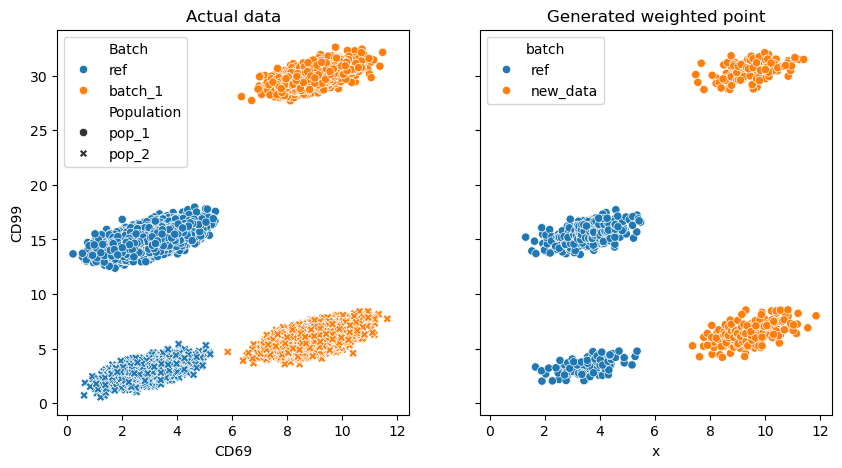

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

# plot the reference data first
sns.scatterplot(
    data=df,
    x='CD69',
    y='CD99',
    hue='Batch',
    style='Population',
    ax=ax[0]
).set_title("Actual data")

sns.scatterplot(
    data=set_points,
    x='x',
    y='y',
    hue='batch',
    ax=ax[1]
).set_title("Generated weighted point")


# CPD

Test few CPDs while add in some diagnostics.

From cycpd animation, it may well be best that:

1. The weighted set points for new data is more concentrated in the center (area with very high probability) - lots of it, and as CPD iteration undergoes, it expands. Have some points at the border, but not as many. 
2. More weighted points for reference than new data?

## Explanations on what CPD is

**Coherent Point Drift (CPD)** is a probabilistic method for aligning point sets, aiming to find both correspondences and the transformation between two sets of points. There are two main types of transformations in CPD: **rigid** (allowing only translation, rotation, and uniform scaling) and **non-rigid** (which includes more flexible deformations, such as affine transformations and smooth, non-linear warps). Note that in strict mathematical terms, rigid transformations do not include scaling (they only preserve distances), but in CPD literature, "rigid" often refers to similarity transformations, which do include uniform scaling. Affine transformations can include anisotropic scaling and skewing, but the most general non-rigid CPD models go beyond affine to allow smooth, coherent, non-linear deformations.

In CPD, one point set (typically called `Y`, the "template" or "moving" set) is represented as the centroids of a Gaussian Mixture Model (GMM), and the other (`X`, the "reference" or "fixed" set) is treated as data points generated from this GMM. The algorithm iteratively transforms `Y` to maximize the likelihood that `X` was generated by this GMM, moving `Y` coherently to best align with `X`[.

The reason this is called a GMM and not just a normal distribution is that the model assumes the data comes from several clusters, each represented by a Gaussian (normal distribution) with its own center (mean), spread (covariance), and weight (mixing coefficient). In CPD, each point in `Y` is the center of a Gaussian, and the mixture of all these Gaussians forms the GMM.
***This is why we want to use PPM as otherwise we will have too many points.***

All GMM components in standard CPD are typically given equal isotropic covariance (`\sigma^2`) and equal membership probabilities (mixing coefficients), except for an additional uniform distribution component that handles outliers. The set of all GMM parameters (means, covariances, and mixing coefficients) is collectively referred to as `\theta`. The membership probabilities (mixing coefficients) indicate the prior likelihood that a randomly chosen data point comes from each Gaussian component.

The optimization is performed using the Expectation-Maximization (EM) algorithm. In the **Expectation step**, CPD computes the posterior probabilities (soft assignments) that each point in `X` was generated by each Gaussian in the GMM, using Bayes' theorem. The uniform distribution component ensures robustness to noise and outliers by allowing some points in `X` to be explained as outliers rather than forcing a match to `Y`.

In the **Maximization step**, CPD updates the transformation parameters (rotation, translation, scaling, and, for non-rigid, deformation parameters) to maximize the likelihood (or equivalently, minimize the negative log-likelihood) of `X` given the current GMM centroids (transformed `Y`). For rigid registration, the optimal rotation is found using Singular Value Decomposition (SVD) on a weighted cross-covariance matrix, while translation and scaling are updated using closed-form formulas based on weighted means. This process is repeated until convergence.



## Few things to think about

One thing to think about is given a user's dataset, how are we to know which set of gates to test the CPD on first?
E.g., If the user has a set of T cells, you would want to only pick the gating strategy for resolving T cells, not B cells.
But how are we to know this?

The code generate the animation of the data post each iteration.

In [20]:
def visualize(iteration, error, X, Y, ax, fig, plt_prefix, save_fig=False):
    plt.cla()
    ax.cla()

    ax.scatter(X[:, 0], X[:, 1], color="blue", label="Target", alpha=0.5, s=3)
    ax.scatter(Y[:, 0], Y[:, 1], color="orange", label="Source", alpha=0.8, s=3)
    ax.legend(loc="upper left", fontsize="x-large")
    ax.text(
        0.87,
        0.92,
        "Iteration: {:d}\nError: {:06.4f}".format(iteration, error),
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize="x-large",
    )
    plt.draw()
    if save_fig is True:
        fig.savefig("../plots/{}/{}_{:04}.tiff".format(plt_prefix, plt_prefix, iteration))  # Used for making gif.

    plt.pause(0.001)

## Rigid registration

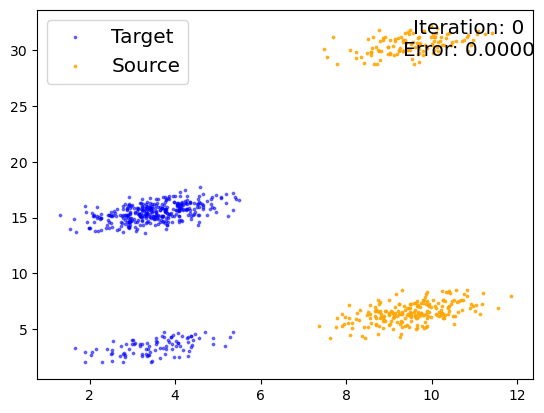

Iteration:1
ML:  -194.210; 	ML change (error):   194.210; 	Sigma^2:    11.904; 	Sigma^2 change:    87.532
[                                                                        ]


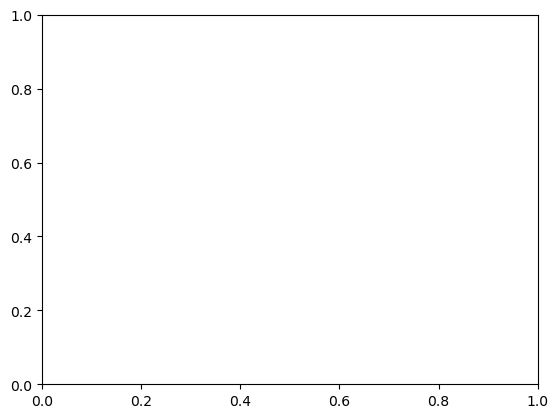

Iteration:2
ML: -1032.373; 	ML change (error):   838.163; 	Sigma^2:    10.996; 	Sigma^2 change:     0.908
[=                                                                       ]


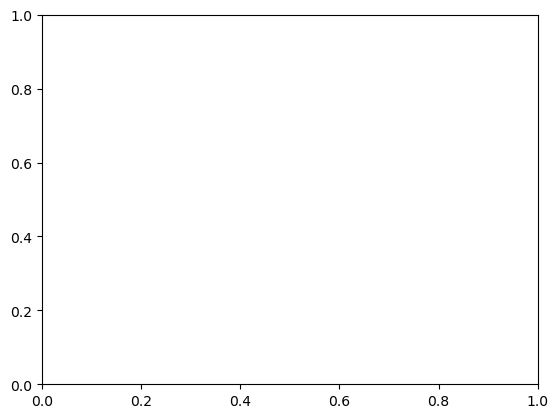

Iteration:3
ML: -1046.004; 	ML change (error):    13.631; 	Sigma^2:    10.347; 	Sigma^2 change:     0.649
[==                                                                      ]


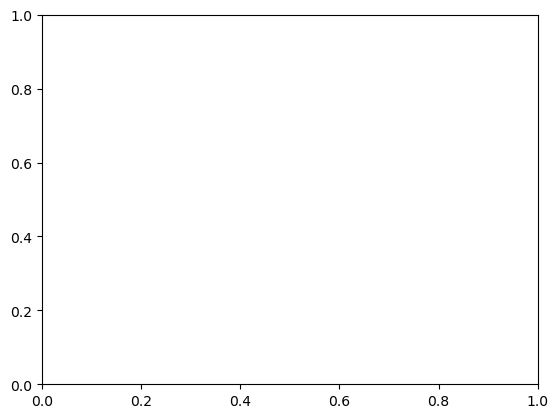

Iteration:4
ML: -1051.780; 	ML change (error):     5.777; 	Sigma^2:     9.817; 	Sigma^2 change:     0.529
[==                                                                      ]


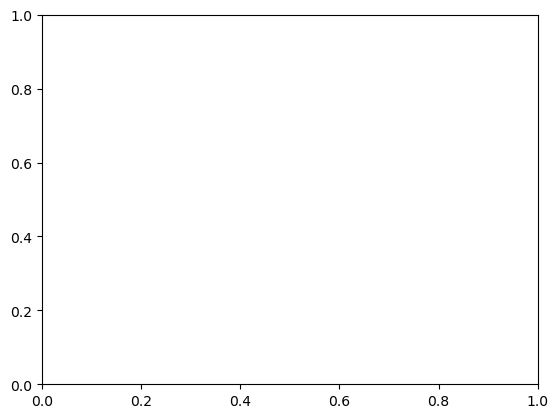

Iteration:5
ML: -1055.979; 	ML change (error):     4.199; 	Sigma^2:     9.312; 	Sigma^2 change:     0.505
[===                                                                     ]


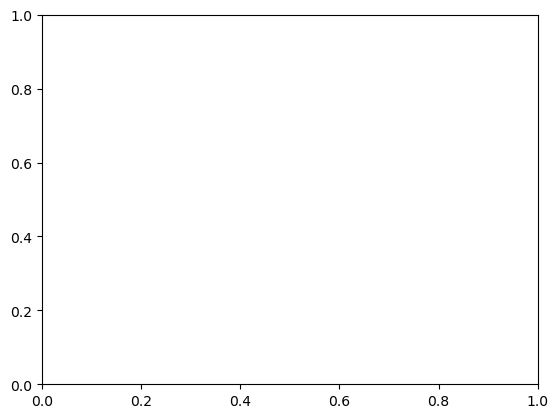

Iteration:6
ML: -1060.616; 	ML change (error):     4.637; 	Sigma^2:     8.704; 	Sigma^2 change:     0.608
[====                                                                    ]


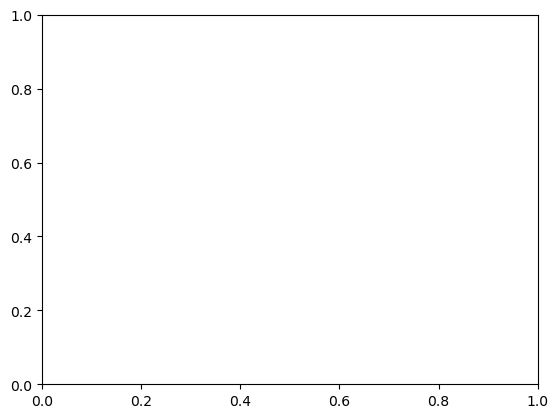

Iteration:7
ML: -1068.642; 	ML change (error):     8.026; 	Sigma^2:     7.766; 	Sigma^2 change:     0.938
[=====                                                                   ]


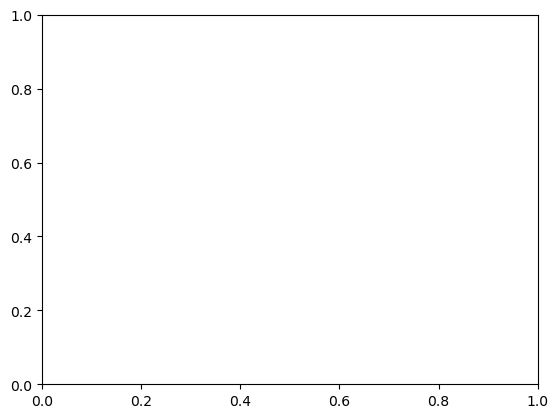

Iteration:8
ML: -1091.779; 	ML change (error):    23.137; 	Sigma^2:     5.823; 	Sigma^2 change:     1.942
[=====                                                                   ]


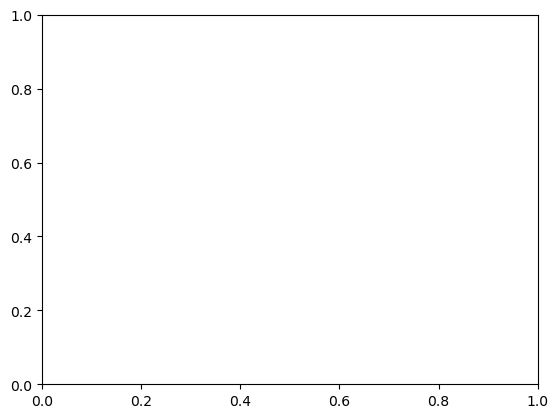

Iteration:9
ML: -1208.607; 	ML change (error):   116.828; 	Sigma^2:     1.605; 	Sigma^2 change:     4.218
[======                                                                  ]


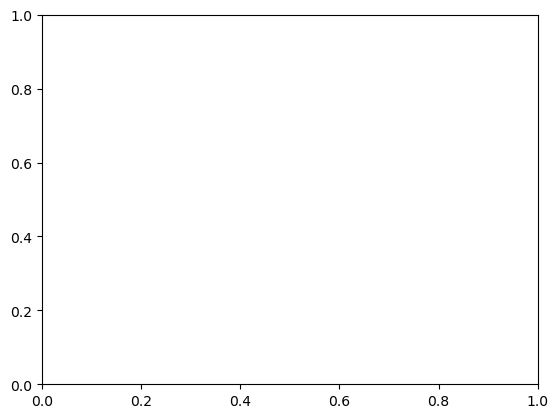

Iteration:10
ML: -1770.386; 	ML change (error):   561.779; 	Sigma^2:     0.620; 	Sigma^2 change:     0.986
[=======                                                                 ]


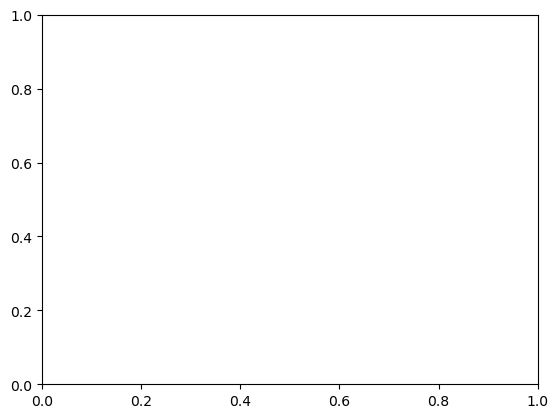

Iteration:11
ML: -1979.113; 	ML change (error):   208.727; 	Sigma^2:     0.469; 	Sigma^2 change:     0.151
[=======                                                                 ]


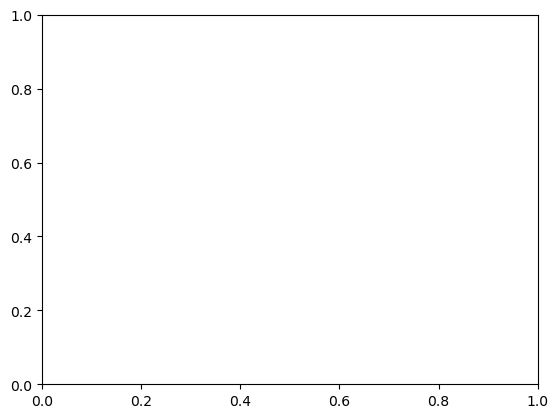

Iteration:12
ML: -2003.094; 	ML change (error):    23.981; 	Sigma^2:     0.415; 	Sigma^2 change:     0.054
[========                                                                ]


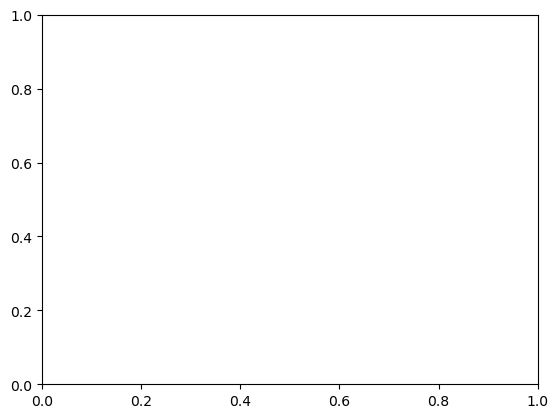

Iteration:13
ML: -2008.210; 	ML change (error):     5.116; 	Sigma^2:     0.391; 	Sigma^2 change:     0.024
[=========                                                               ]


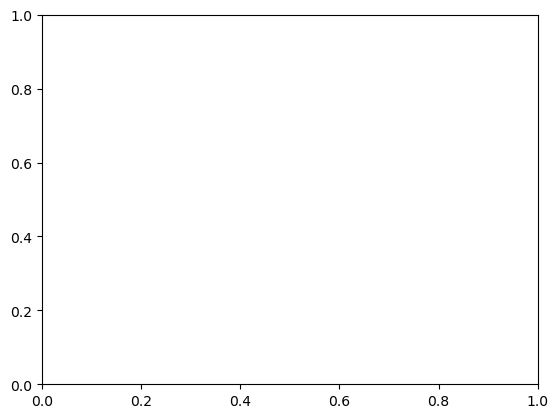

Iteration:14
ML: -2009.513; 	ML change (error):     1.303; 	Sigma^2:     0.379; 	Sigma^2 change:     0.012
[==========                                                              ]


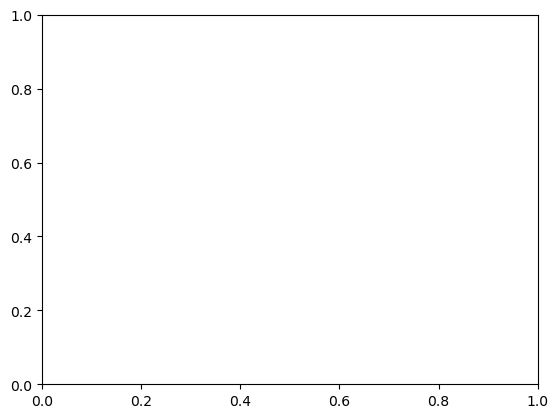

Iteration:15
ML: -2009.871; 	ML change (error):     0.358; 	Sigma^2:     0.373; 	Sigma^2 change:     0.006
[==========                                                              ]


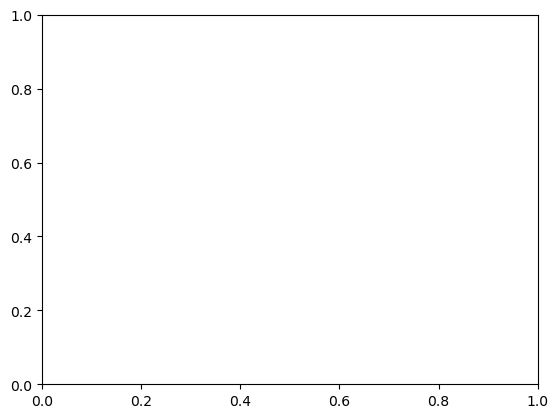

Iteration:16
ML: -2009.973; 	ML change (error):     0.102; 	Sigma^2:     0.369; 	Sigma^2 change:     0.003
[===========                                                             ]


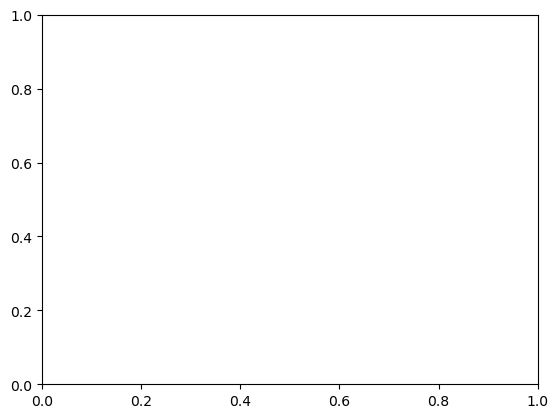

Iteration:17
ML: -2010.003; 	ML change (error):     0.030; 	Sigma^2:     0.368; 	Sigma^2 change:     0.002
[============                                                            ]


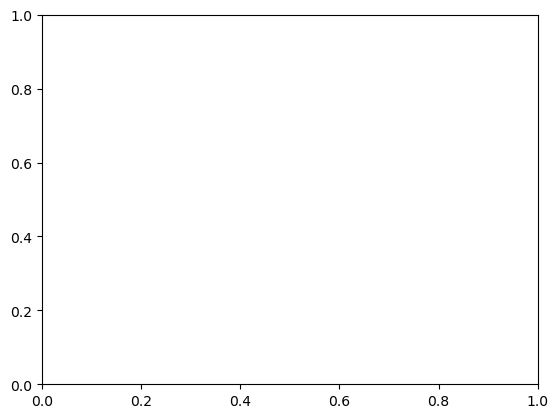

Iteration:18
ML: -2010.012; 	ML change (error):     0.009; 	Sigma^2:     0.367; 	Sigma^2 change:     0.001
[============                                                            ]


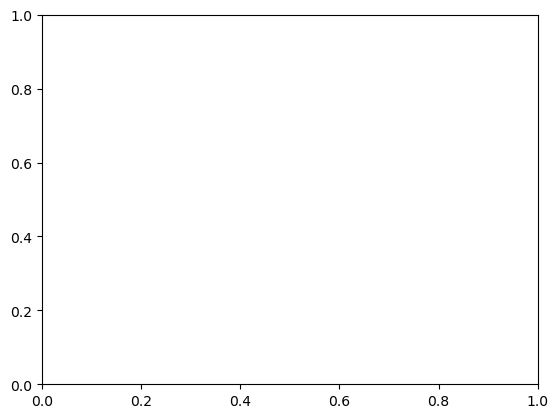

Iteration:19
ML: -2010.014; 	ML change (error):     0.003; 	Sigma^2:     0.366; 	Sigma^2 change:     0.001
[=============                                                           ]


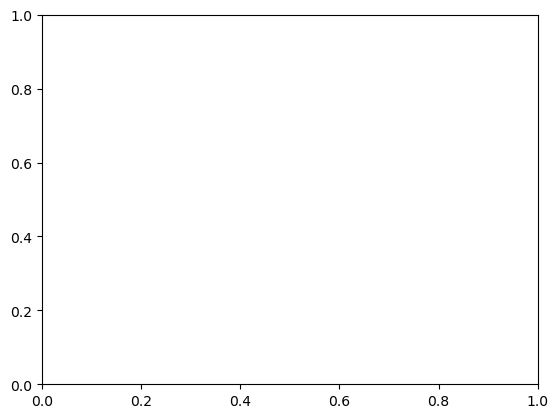

Iteration:20
ML: -2010.015; 	ML change (error):     0.001; 	Sigma^2:     0.366; 	Sigma^2 change:     0.000
[==============                                                          ]


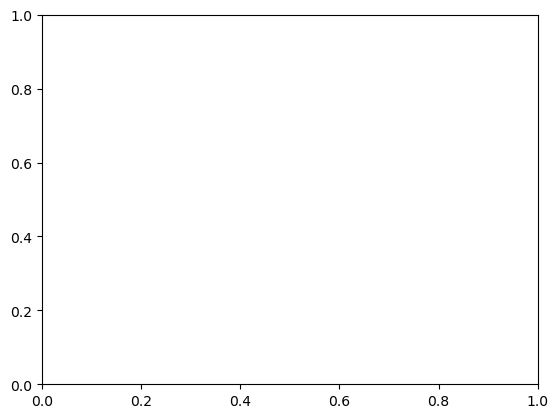

Iteration:21
ML: -2010.015; 	ML change (error):     0.000; 	Sigma^2:     0.366; 	Sigma^2 change:     0.000
[===============                                                         ]


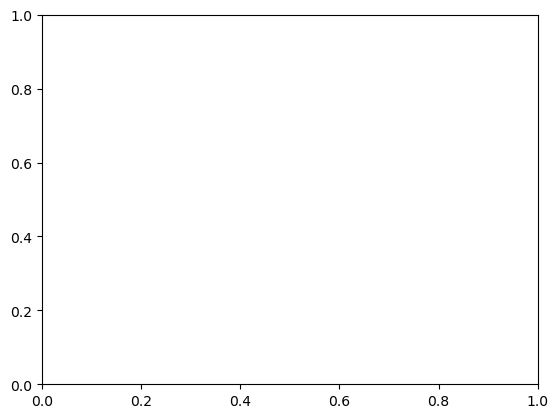

Iteration:22
ML: -2010.015; 	ML change (error):     0.000; 	Sigma^2:     0.366; 	Sigma^2 change:     0.000
[===============                                                         ]


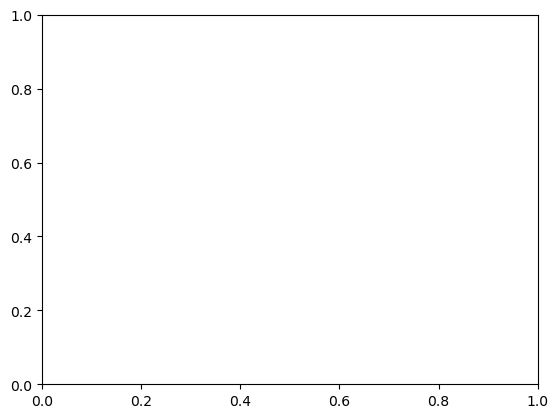

Iteration:23
ML: -2010.015; 	ML change (error):     0.000; 	Sigma^2:     0.366; 	Sigma^2 change:     0.000
[================                                                        ]


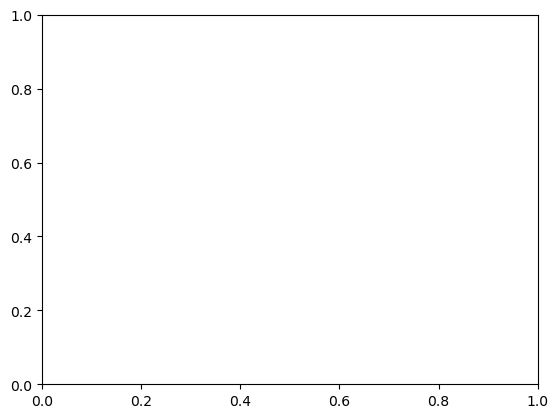

Iteration:24
ML: -2010.015; 	ML change (error):     0.000; 	Sigma^2:     0.366; 	Sigma^2 change:     0.000
[=================                                                       ]


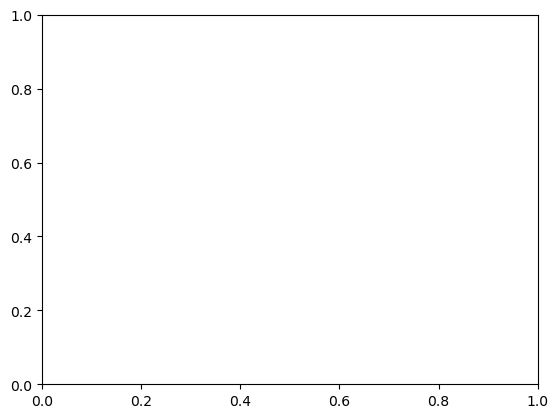

Registration Performance Metrics
Time to initialize EM: 0.00033283233642578125
Time to initialize registration: 2.09808349609375e-05
Average Expectation Time:                    0.0009 +/- 0.0001
Average Maximization Time:                   0.0002 +/- 0.0000
Maximization Times - Per individual step
Average Update Transform Time:               0.0002 +/- 0.0000
Average Transform Time:                      0.0000 +/- 0.0000
Average Update Variance Time:                0.0000 +/- 0.0000

Number of iterations performed:          24
Error at time of finish:                 6.0033012232452165e-06


In [54]:
fig, ax = plt.subplots(1,1)

visualize(
    iteration = 0,
    error = 0,
    X = ref_set_points,
    Y = new_dat_set_points,
    ax=ax, fig=fig, plt_prefix="rigid", save_fig=True
)

callback = partial(visualize, ax=ax, fig=fig, plt_prefix="rigid", save_fig=True)

reg = rigid_registration(**{'X': ref_set_points, 'Y': new_dat_set_points, 'scale': True})
# The above shows an example where we dont "test" or determine the scale.
# This makes it clear the CPD first actually shrinks the mesh and then "grows" it iteratively to make it
# best fit the data.
reg.register(callback)
# plt.show()

# List your TIFF filenames in the desired order
tiff_files = [f"../plots/rigid/{f}" for f in os.listdir("../plots/rigid") if f.lower().endswith(('.tif', '.tiff'))]
tiff_files.sort()
# Open images and convert to 'P' mode for GIF compatibility
frames = [Image.open(f).convert('P') for f in tiff_files]

# Save as GIF
frames[0].save(
    "../plots/rigid/output.gif",
    save_all=True,
    append_images=frames[1:],
    duration=300,   # duration per frame in ms
    loop=0          # 0 means loop forever
)

## Affine and deformable

In [ ]:
# theta = np.pi / 6.0
# R = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
# t = np.array([0.5, 1.0, -2.0])

fig, ax = plt.subplots(1,1)

visualize(
    iteration = 0,
    error = 0,
    X = ref_set_points,
    Y = new_dat_set_points,
    ax=ax, fig=fig, plt_prefix="affine", save_fig=True
)

callback = partial(visualize, ax=ax, fig=fig, plt_prefix="affine", save_fig=True)

reg = affine_registration(**{'X': ref_set_points, 'Y': new_dat_set_points, 'scale': True})
# The above shows an example where we dont "test" or determine the scale.
# This makes it clear the CPD first actually shrinks the mesh and then "grows" it iteratively to make it
# best fit the data.
reg.register(callback)
plt.show()

# List your TIFF filenames in the desired order
tiff_files = [f"../plots/affine/{f}" for f in os.listdir("../plots/affine") if f.lower().endswith(('.tif', '.tiff'))]
tiff_files.sort()
# Open images and convert to 'P' mode for GIF compatibility
frames = [Image.open(f).convert('P') for f in tiff_files]

# Save as GIF
frames[0].save(
    "../plots/affine/output.gif",
    save_all=True,
    append_images=frames[1:],
    duration=300,   # duration per frame in ms
    loop=0          # 0 means loop forever
)

In [ ]:
fig, ax = plt.subplots(1,1)

visualize(
    iteration = 0,
    error = 0,
    X = ref_set_points,
    Y = new_dat_set_points,
    ax=ax, fig=fig, plt_prefix="deformable", save_fig=True
)

callback = partial(visualize, ax=ax, fig=fig, plt_prefix="deformable", save_fig=True)

reg = deformable_registration(**{'X': ref_set_points, 'Y': new_dat_set_points, 'scale': True})
# The above shows an example where we dont "test" or determine the scale.
# This makes it clear the CPD first actually shrinks the mesh and then "grows" it iteratively to make it
# best fit the data.
reg.register(callback)
plt.show()

# List your TIFF filenames in the desired order
tiff_files = [f"../plots/deformable/{f}" for f in os.listdir("../plots/deformable") if f.lower().endswith(('.tif', '.tiff'))]
tiff_files.sort()
# Open images and convert to 'P' mode for GIF compatibility
frames = [Image.open(f).convert('P') for f in tiff_files]

# Save as GIF
frames[0].save(
    "../plots/deformable/output.gif",
    save_all=True,
    append_images=frames[1:],
    duration=300,   # duration per frame in ms
    loop=0          # 0 means loop forever
)

Hmm, weird how deformable and affine didn't work well. Best don't bother with it for now.

In [55]:
errors = []
def append_error(iteration, error, X, Y):
    errors.append(error)

# set scale to False so we don't stretch or squezze the new data points
reg = rigid_registration(**{
    'X': ref_set_points, 
    'Y': new_dat_set_points, 
    'scale': True, 
    'verbose': True
})

TY, (s_reg, R_reg, t_reg) = reg.register(partial(append_error))


Iteration:1
ML:  -194.210; 	ML change (error):   194.210; 	Sigma^2:    11.904; 	Sigma^2 change:    87.532
[                                                                        ]
Iteration:2
ML: -1032.373; 	ML change (error):   838.163; 	Sigma^2:    10.996; 	Sigma^2 change:     0.908
[=                                                                       ]
Iteration:3
ML: -1046.004; 	ML change (error):    13.631; 	Sigma^2:    10.347; 	Sigma^2 change:     0.649
[==                                                                      ]
Iteration:4
ML: -1051.780; 	ML change (error):     5.777; 	Sigma^2:     9.817; 	Sigma^2 change:     0.529
[==                                                                      ]
Iteration:5
ML: -1055.979; 	ML change (error):     4.199; 	Sigma^2:     9.312; 	Sigma^2 change:     0.505
[===                                                                     ]
Iteration:6
ML: -1060.616; 	ML change (error):     4.637; 	Sigma^2:     8.704; 	Sigma^2 change:

In [56]:
# final parameters to transform Y to X.
print(f"s: {s_reg}, r: {R_reg}, t: {t_reg}")

s: 0.503772663350198, r: [[ 9.99999519e-01  9.81156772e-04]
 [-9.81156772e-04  9.99999519e-01]], t: [-1.27054599  0.12854733]


Rotation matrix is close to identity matrix.
Means only a small amount of rotation was done.
The off-diagonal values (+/-0.00426) show the sine of the rotation angle; the diagonal values (≈0.99999) show the cosine.
See transformation below.


In [57]:
# The matrix rotates points counterclockwise by rot_deg degree about the origin
# R is [[cos, -sin], [sin, cos]]
# this is in radian, so have to convert to degree
# or just np.arccos(r_factor[0][0])
rot_deg = np.arctan2(R_reg[1][0], R_reg[1][1]) * 180 / np.pi
rot_deg

np.float64(-0.056216151079728535)

Scaling factor less than 1, meaning the points are shrunk to best align the reference.
Any value greater than 1 means it is enlarged.

Translation factor is just the amount of shifting.
Weirdly, the values don't translate to the unit of the data?

In [58]:
from pycpd import RigidRegistration

reg_pycpd = RigidRegistration(X=ref_set_points, Y=new_dat_set_points, scale=True)
TY_pycpd, (s_reg_pycpd, R_reg_pycpd, t_reg_pycpd) = reg_pycpd.register()


In [59]:
print(f"s_pycpd: {s_reg_pycpd}, r_pycpd: {R_reg_pycpd}, t_pycpd: {t_reg_pycpd}\ns: {s_reg}, r: {R_reg}, t: {t_reg}")

s_pycpd: 0.5037745031711751, r_pycpd: [[ 9.99999520e-01  9.79389472e-04]
 [-9.79389472e-04  9.99999520e-01]], t_pycpd: [-1.27058477  0.1285102 ]
s: 0.503772663350198, r: [[ 9.99999519e-01  9.81156772e-04]
 [-9.81156772e-04  9.99999519e-01]], t: [-1.27054599  0.12854733]


I think the two packages are very very similar.

Plot the new data

In [76]:
ref_set_points_df = pd.DataFrame(ref_set_points, columns=['CD69', 'CD99'])
ref_set_points_df.loc[:, "bin_id"] = ref_set_points_bin_ids
# based on each bin get the label with most points and give that bin that label
ref_bin_labels = df_ref_with_bins.groupby('bin_id')['Population'].agg(lambda x: x.value_counts().idxmax())

ref_set_points_df['Population'] = ref_set_points_df['bin_id'].map(ref_bin_labels)
ref_set_points_df['batch'] = 'ref'
ref_set_points_df


,CD69,CD99,bin_id,Population,batch
0,1.304709,15.215318,bin_5_25,pop_1,ref
1,1.530106,13.947489,bin_6_23,pop_1,ref
2,1.930661,14.629194,bin_6_24,pop_1,ref
3,1.626598,14.842978,bin_6_25,pop_1,ref
4,1.662281,3.308591,bin_7_3,pop_2,ref
...,...,...,...,...,...
443,5.187742,16.298701,bin_27_27,pop_1,ref
444,5.482395,16.593946,bin_27_28,pop_1,ref
445,5.197818,17.101280,bin_27_29,pop_1,ref
446,5.398296,16.888445,bin_28_28,pop_1,ref


In [77]:
new_dat_set_points_df = pd.DataFrame(TY, columns=['CD69', 'CD99'])
new_dat_set_points_df.loc[:, "bin_id"] = new_dat_set_points_bin_ids
new_dat_set_points_df['batch'] = 'new_data'
new_dat_set_points_df

,CD69,CD99,bin_id,batch
0,2.437091,2.778383,bin_6_1,new_data
1,2.638993,2.758409,bin_7_1,new_data
2,2.744239,3.194058,bin_7_2,new_data
3,2.567211,2.272096,bin_8_0,new_data
4,2.735727,2.899293,bin_8_1,new_data
...,...,...,...,...
326,4.459037,16.005930,bin_26_30,new_data
327,4.546716,3.608364,bin_27_3,new_data
328,4.367971,4.279794,bin_27_4,new_data
329,4.299519,16.094048,bin_27_30,new_data


<Axes: xlabel='CD69', ylabel='CD99'>

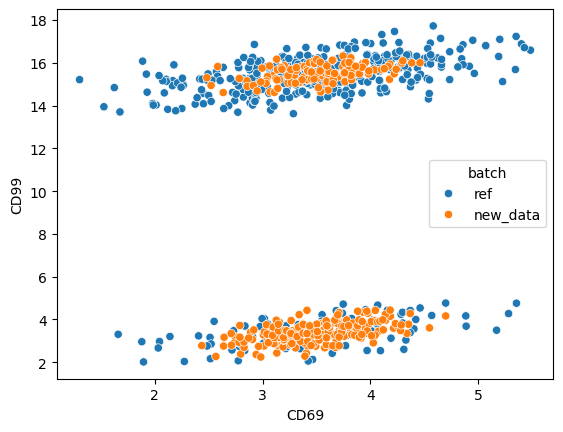

In [85]:
all_df = pd.concat([ref_set_points_df, new_dat_set_points_df])

sns.scatterplot(
    data = all_df,
    x = 'CD69',
    y = 'CD99',
    hue='batch',
)

# Lable the PPM of the new data

Assuming our reference PPM is already labelled, train kNN on the labelled weighted points (based on the PPM bin it falls to and the label assigned to that bin) to label the new data's weighted points.

From there, compute the majority label for the bin and assign the label.

In [86]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(
    ref_set_points_df[['CD69', 'CD99']].to_numpy(), 
    ref_set_points_df['Population'].to_numpy()
)

pred_labels = neigh.predict(new_dat_set_points_df[['CD69', 'CD99']].to_numpy())
new_dat_set_points_df.loc[:, 'Population'] = pred_labels

<Axes: xlabel='CD69', ylabel='CD99'>

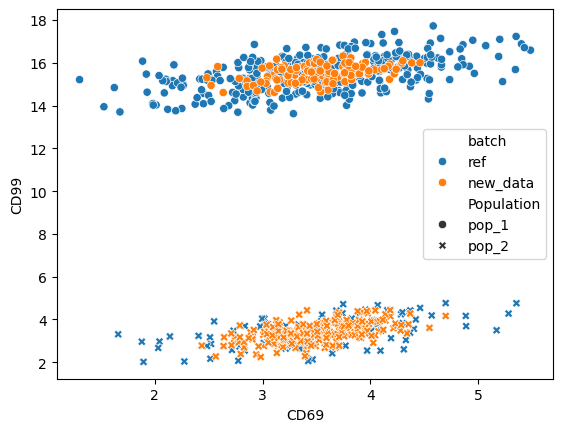

In [87]:
all_df = pd.concat([ref_set_points_df, new_dat_set_points_df])

sns.scatterplot(
    data = all_df,
    x = 'CD69',
    y = 'CD99',
    hue='batch',
    style = 'Population'
)

In [88]:
# find the label for each bin based on majority
new_dat_bin_labels = new_dat_set_points_df.groupby('bin_id')['Population'].agg(lambda x: x.value_counts().idxmax())
new_dat_bin_labels

bin_id
bin_10_0     pop_2
bin_10_1     pop_2
bin_10_2     pop_2
bin_10_27    pop_1
bin_10_28    pop_1
             ...  
bin_9_1      pop_2
bin_9_2      pop_2
bin_9_27     pop_1
bin_9_28     pop_1
bin_9_29     pop_1
Name: Population, Length: 132, dtype: object

In [92]:
ppm_dat_bin_coords.loc[:, "Population"] = ppm_dat_bin_coords['bin_id'].map(new_dat_bin_labels)
ppm_dat_bin_coords

,bin_id,x_min,x_max,x_center,y_min,y_max,y_center,prob,Population
0,bin_0_0,5.837498,6.018641,5.928070,3.577362,4.485079,4.031220,0.000000,NaN
1,bin_0_1,5.837498,6.018641,5.928070,4.485079,5.392796,4.938938,0.000111,NaN
2,bin_0_2,5.837498,6.018641,5.928070,5.392796,6.300514,5.846655,0.000000,NaN
3,bin_0_3,5.837498,6.018641,5.928070,6.300514,7.208231,6.754372,0.000000,NaN
4,bin_0_4,5.837498,6.018641,5.928070,7.208231,8.115948,7.662090,0.000000,NaN
...,...,...,...,...,...,...,...,...,...
1019,bin_31_27,11.452935,11.634078,11.543506,28.085729,28.993447,28.539588,0.000000,NaN
1020,bin_31_28,11.452935,11.634078,11.543506,28.993447,29.901164,29.447305,0.000000,NaN
1021,bin_31_29,11.452935,11.634078,11.543506,29.901164,30.808881,30.355023,0.000000,NaN
1022,bin_31_30,11.452935,11.634078,11.543506,30.808881,31.716599,31.262740,0.000000,NaN


For bin with no label because no weighted set points were generated, train knn on the labelled bins and label those nan ones.

In [97]:
ppm_dat_bin_coords_nolabs = ppm_dat_bin_coords[ppm_dat_bin_coords['Population'].isna()]
ppm_dat_bin_coords_labs = ppm_dat_bin_coords[~ppm_dat_bin_coords['Population'].isna()]

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(
    ppm_dat_bin_coords_labs[['x_center', 'y_center']].to_numpy(), 
    ppm_dat_bin_coords_labs['Population'].to_numpy()
)

pred_labels = neigh.predict(ppm_dat_bin_coords_nolabs[['x_center', 'y_center']].to_numpy())
ppm_dat_bin_coords_nolabs.loc[:, 'Population'] = pred_labels

ppm_dat_bin_coords_nolabs

,bin_id,x_min,x_max,x_center,y_min,y_max,y_center,prob,Population
0,bin_0_0,5.837498,6.018641,5.928070,3.577362,4.485079,4.031220,0.000000,pop_2
1,bin_0_1,5.837498,6.018641,5.928070,4.485079,5.392796,4.938938,0.000111,pop_2
2,bin_0_2,5.837498,6.018641,5.928070,5.392796,6.300514,5.846655,0.000000,pop_2
3,bin_0_3,5.837498,6.018641,5.928070,6.300514,7.208231,6.754372,0.000000,pop_2
4,bin_0_4,5.837498,6.018641,5.928070,7.208231,8.115948,7.662090,0.000000,pop_2
...,...,...,...,...,...,...,...,...,...
1019,bin_31_27,11.452935,11.634078,11.543506,28.085729,28.993447,28.539588,0.000000,pop_1
1020,bin_31_28,11.452935,11.634078,11.543506,28.993447,29.901164,29.447305,0.000000,pop_1
1021,bin_31_29,11.452935,11.634078,11.543506,29.901164,30.808881,30.355023,0.000000,pop_1
1022,bin_31_30,11.452935,11.634078,11.543506,30.808881,31.716599,31.262740,0.000000,pop_1


In [98]:
# merge
ppm_dat_bin_coords_labelled = pd.concat([ppm_dat_bin_coords_nolabs, ppm_dat_bin_coords_labs])
ppm_dat_bin_coords_labelled

,bin_id,x_min,x_max,x_center,y_min,y_max,y_center,prob,Population
0,bin_0_0,5.837498,6.018641,5.928070,3.577362,4.485079,4.031220,0.000000,pop_2
1,bin_0_1,5.837498,6.018641,5.928070,4.485079,5.392796,4.938938,0.000111,pop_2
2,bin_0_2,5.837498,6.018641,5.928070,5.392796,6.300514,5.846655,0.000000,pop_2
3,bin_0_3,5.837498,6.018641,5.928070,6.300514,7.208231,6.754372,0.000000,pop_2
4,bin_0_4,5.837498,6.018641,5.928070,7.208231,8.115948,7.662090,0.000000,pop_2
...,...,...,...,...,...,...,...,...,...
862,bin_26_30,10.547219,10.728362,10.637791,30.808881,31.716599,31.262740,0.000889,pop_1
867,bin_27_3,10.728362,10.909505,10.818934,6.300514,7.208231,6.754372,0.000889,pop_2
868,bin_27_4,10.728362,10.909505,10.818934,7.208231,8.115948,7.662090,0.000778,pop_2
894,bin_27_30,10.728362,10.909505,10.818934,30.808881,31.716599,31.262740,0.000778,pop_1


In [102]:
# label the new data from bin
ppm_dat_labs = ppm_dat_bin_coords_labelled['Population']
ppm_dat_labs.index = ppm_dat_bin_coords_labelled['bin_id']

df_new_with_bins['Pred_Population'] = df_new_with_bins['bin_id'].map(ppm_dat_labs)
df_new_with_bins

,CD69,CD99,Population,Batch,bin_id,Pred_Population
10000,8.690130,29.869319,pop_1,user_data,bin_15_28,pop_1
10001,9.409027,30.775588,pop_1,user_data,bin_19_29,pop_1
10002,10.149282,30.735540,pop_1,user_data,bin_23_29,pop_1
10003,9.771453,31.757215,pop_1,user_data,bin_21_31,pop_1
10004,8.461216,30.831674,pop_1,user_data,bin_14_30,pop_1
...,...,...,...,...,...,...
20995,7.998426,6.030827,pop_2,user_data,bin_11_2,pop_2
20996,7.307562,5.361594,pop_2,user_data,bin_8_1,pop_2
20997,8.685056,5.468616,pop_2,user_data,bin_15_2,pop_2
20998,8.649926,6.064332,pop_2,user_data,bin_15_2,pop_2


<Axes: xlabel='CD69', ylabel='CD99'>

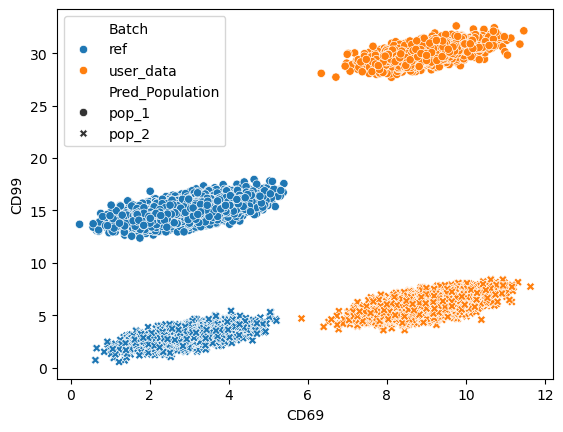

In [104]:
df_ref_with_bins['Pred_Population'] = df_ref_with_bins['Population']
all_df = pd.concat([df_ref_with_bins, df_new_with_bins])

sns.scatterplot(
    data = all_df,
    x = 'CD69',
    y = 'CD99',
    hue='Batch',
    style = 'Pred_Population'
)

In [109]:
np.unique(y_true)

array(['pop_1', 'pop_2'], dtype=object)

In [110]:
# some metrics?
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = df_new_with_bins['Population'].to_numpy()
y_pred = df_new_with_bins['Pred_Population'].to_numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label='pop_1')
recall = recall_score(y_true, y_pred, pos_label='pop_1')
f1 = f1_score(y_true, y_pred, pos_label='pop_1')

print(f'Accuracy:  {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall:    {recall:.2f}')
print(f'F1 Score:  {f1:.2f}')


Accuracy:  1.00
Precision: 1.00
Recall:    1.00
F1 Score:  1.00
